# Import Package

In [1]:
%matplotlib inline    
import pandas as pd
import numpy as np
import pylab as plt
import nltk
import seaborn
from gensim import corpora, models, similarities
import networkx as nx
import community
seaborn.set()
from collections import Counter

# Read Data

In [2]:
train = pd.read_table('./Data/training_set.txt',sep=' ',names=['source','target','link'])
train.head()

,source,target,link
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0
3,9911255,302165,0
4,9701033,209076,0


In [3]:
test = pd.read_table('./Data/testing_set.txt',sep=' ',names=['source','target'])
test.head()

,source,target
0,9807076,9807139
1,109162,1182
2,9702187,9510135
3,111048,110115
4,9910176,9410073


In [4]:
node_information = pd.read_csv('./Data/node_information.csv',names=['id','year','title','author','journal','abstract'])
node_information.head()

,id,year,title,author,journal,abstract
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...
3,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
4,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...


In [6]:
node_information[node_information.id == 9601043]

,id,year,title,author,journal,abstract
17403,9601043,1996,wilsonian approximated renormalization group f...,NaN,Phys.Lett.,models in 2 d 4 subleading exponents supplemen...


### For Example

In [5]:
node_information[node_information.id == 9207016]

,id,year,title,author,journal,abstract
10789,9207016,1992,noncompact symmetries in string theory,"Jnan Maharana, John H. Schwarz",Nucl.Phys.,noncompact groups similar to those that appear...


In [6]:
author_split = []
for au in node_information.author:
    try:
        author_split.append(au.split(','))
    except:
        author_split.append(au)
node_information['author_split'] = author_split
node_information.head(2)

,id,year,title,author,journal,abstract,author_split
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...,[Paul S. Aspinwall]
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...,"[M. Cvetic, H. Lu, C.N. Pope]"


In [43]:
node_information_ = node_information[['id','year','title','author','journal','abstract']].head(0)

i =0
info = node_information.ix[i,:]
info_ = list(info[['id','year','journal']].values)
author_length = len(info.author_split)
author_split = np.array(info.author_split)
author_length
info_s = [] 
for i in range(author_length):
    info_s.append(info_)
Data = np.hstack([info_s,author_split[:,np.newaxis]])


for i in range(1,len(node_information))[:30]:
    info = node_information.ix[i,:]
    info_ = list(info[['id','year','journal']].values)
    try:        
        author_length = len(info.author_split)
        author_split = np.array(info.author_split)
        author_length
        info_s = [] 
        for i in range(author_length):
            info_s.append(info_)
        data = np.hstack([info_s,author_split[:,np.newaxis]])
    except:
        data = info[['id','year','journal','author']].values
    Data = np.vstack([Data,data])
Data_df = pd.DataFrame(Data,columns=[['id','year','journal','author']])

In [6]:
node_information_reshape = pd.read_csv('./Data/node_information_reshape.csv')
node_information_reshape.head()


,id,year,journal,author
0,1001.0,2000.0,NaN,Paul S. Aspinwall
1,1002.0,2000.0,Class.Quant.Grav.,M. Cvetic
2,1002.0,2000.0,Class.Quant.Grav.,H. Lu
3,1002.0,2000.0,Class.Quant.Grav.,C.N. Pope
4,1003.0,2000.0,NaN,Y.S. Myung


# Explore  Year \ Author \ Journal

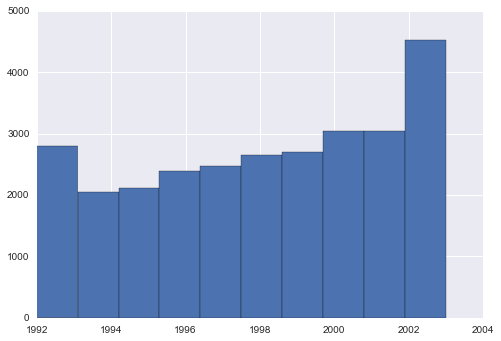

In [6]:
node_information.year.hist()

In [7]:
journal_num = len(set(node_information.journal))
print 'There are '+str(journal_num)+' kinds of journals'
author_num = len(set(node_information.author))
print 'There are '+str(author_num)+' authors'

There are 285 kinds of journals
There are 16351 authors


In [8]:
def sort_dict_value(diction):
    l = list(diction.items())
    sort_l = sorted(l,key = lambda x:x[1] , reverse= True)
    return sort_l

c_journal = Counter(node_information.journal.dropna())
print '\njournal count top 10\n'
top_journal = sort_dict_value(c_journal)[:10]
print top_journal
c_author = Counter(node_information.author.dropna())
print '\nauthor count top 10\n'
top_author = sort_dict_value(c_author)[:10]
print top_author


journal count top 10

[('Phys.Lett.', 3575), ('Nucl.Phys.', 3571), ('Phys.Rev.', 3170), ('JHEP', 1957), ('Int.J.Mod.Phys.', 938), ('Mod.Phys.Lett.', 936), ('Class.Quant.Grav.', 556), ('J.Phys.', 536), ('J.Math.Phys.', 532), ('Phys.Rev.Lett.', 388)]

author count top 10

[("Shin'ichi Nojiri, Sergei D. Odintsov", 38), ('C.M. Hull', 27), ('Edward Witten', 26), ('A.J.M. Medved (University of Alberta)', 19), ('Hitoshi Nishino', 19), ('J.S.Dowker', 19), ('A.A. Tseytlin', 19), ('J. Kluson', 18), ('R. Jackiw', 17), ('M. Cvetic, H. Lu, C.N. Pope', 16)]


### Consider each paper as an object and extract features for it

In [9]:
#node_information[node_information.author == top_author[0][0]]
#node_information[node_information.journal == top_journal[0][0]]

In [10]:
author_mean_year = node_information.pivot_table(values='year',index='author',aggfunc='mean')
nauthor_paper_num_year = node_information.pivot_table(values='id',index=['author','year'],aggfunc='count')
journal_paper_num_year = node_information.pivot_table(values='id',index=['journal','year'],aggfunc='count')
print '\nauthor_mean_year:'
print author_mean_year[:6]
print '\nauthor_paper_num_year:'
print nauthor_paper_num_year[:6]
print '\njournal_paper_num_year:'
print journal_paper_num_year[:6]


author_mean_year:
author
18 pages                                                        1992.0
A Doikou, P P Martin                                            2002.0
A Kundu, Orl, o Ragnisco                                        1994.0
A M Semikhatov, I Yu Tipunin (Lebedev Physics Institute)        1996.5
A M Semikhatov, I Yu Tipunin (P N Lebedev Physics Institute)    1995.5
A M Semikhatov, V A Sirota (Lebedev Physics Institute)          1997.0
Name: year, dtype: float64

author_paper_num_year:
author                                                        year
18 pages                                                      1992    1
A Doikou, P P Martin                                          2002    1
A Kundu, Orl, o Ragnisco                                      1994    1
A M Semikhatov, I Yu Tipunin (Lebedev Physics Institute)      1996    1
                                                              1997    1
A M Semikhatov, I Yu Tipunin (P N Lebedev Physics Institute)  1995    

### categorize journals which the same author once published paper on that 

In [11]:
def get_set(texts):
    return set(texts)

journal_raw_group = node_information.dropna().pivot_table(values = 'journal',index = 'author',aggfunc = get_set).values

journal_raw_group_set = []
for g in journal_raw_group:
    if g not in journal_raw_group_set:
        journal_raw_group_set.append(g)
    else:
        pass
len(journal_raw_group_set)

896

### Combine small and duplicated group into big groups

In [12]:
def combine_set(sets,n,depth):
    sets_sort = sorted(sets,key=lambda x : len(x) ,reverse=True)
    big_sets = [sets_sort[0]] # The Biggest set
    
    while True:
        
        for d in range(depth):          
            # First round
            remove = []
            for s in sets_sort:
                if len(s & big_sets[-1]) >= n or len(s - big_sets[-1]) == 0 :
                    big_sets[-1] = big_sets[-1] | s  # combine to the largest set which matchs the condition
                    remove.append(s)
            for r in remove:
                sets_sort.remove(r)
                
        if len(sets_sort) == 0:
            break
            
        big_sets.append(sets_sort[0])  # The biggest set remain        
    return big_sets

In [13]:
journal_raw_group_sort = sorted(journal_raw_group_set,key=lambda x : len(x) ,reverse=True)
journal_group = combine_set(journal_raw_group_sort,2,3)
print 'Top 10 set(combined) size : ' 
print [len(a) for a in journal_group][:10]

Top 10 set(combined) size : 
[100, 3, 2, 2, 2, 2, 2, 2, 2, 2]


### Those 100 journals in the biggest set have more relation with each other , so give a tag for them as journal's feature / Paper can map to journal so it can used as paper's feature

## journal_tag_dict

In [14]:
high_related_journal = journal_group[0]
journals = list(set(node_information.journal.dropna()))
journal_tag = [1 if j in high_related_journal else 0 for j in journals]

In [15]:
journal_tag_dict = dict(zip(journals,journal_tag))

# Explore Title \ Abstract

In [16]:
titles = list(node_information.title.values)
ids = list(node_information.id.values)
abstracts = list(node_information.abstract.values)

## id_title_vector_dict

In [17]:
titles = [t.lower().split() for t in titles]
dictionary_title = corpora.Dictionary(titles)
corpus_title = [dictionary_title.doc2bow(text) for text in titles]
tfidf_title = models.TfidfModel(corpus_title)
corpus_tfidf_title = tfidf_title[corpus_title]
lsi = models.LsiModel(corpus_tfidf_title, id2word=dictionary_title, num_topics=200) # initialize an LSI transformation
corpus_lsi_title = lsi[corpus_tfidf_title] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [18]:
id_title_vector_dict = dict(zip(ids,list(corpus_lsi_title)))

## id_abstract_vector_dict

In [19]:
abstracts = [t.lower().split() for t in abstracts]
dictionary_abstract = corpora.Dictionary(abstracts)
corpus_abstract = [dictionary_abstract.doc2bow(text) for text in abstracts]
tfidf_abstract = models.TfidfModel(corpus_abstract)
corpus_tfidf_abstract = tfidf_abstract[corpus_abstract]
lsi = models.LsiModel(corpus_tfidf_abstract, id2word=dictionary_abstract, num_topics=200) # initialize an LSI transformation
corpus_lsi_abstract = lsi[corpus_tfidf_abstract] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [20]:
id_abstract_vector_dict = dict(zip(ids,list(corpus_lsi_abstract)))

# Explore Graph Information

In [21]:
G = nx.Graph()

In [22]:
train_link = train[train.link == 1][['source','target']]
train_link.values

array([[9510123, 9502114],
       [9707075, 9604178],
       [9710020, 9709228],
       ..., 
       [9704211, 9311015],
       [ 207232,  111196],
       [9903162, 9805114]])

In [23]:
G.add_edges_from(train_link.values)

In [24]:
id_degree_dict = G.degree()

In [79]:
id_degree_dict.items()[:10]

[(9306112, 2),
 (9306114, 2),
 (9306115, 2),
 (9306116, 2),
 (9306117, 19),
 (9306118, 5),
 (9306119, 10),
 (9306120, 7),
 (9306122, 17),
 (9306123, 2)]

In [25]:
#id_bc_dict = nx.betweenness_centrality(G)

In [34]:
def Sort_Dict(Diction):
    L = list(Diction.items())
    Sort_L = sorted(L,key = lambda x:x[1] , reverse= True)
    return Sort_L

def DrawGraph(G):
    plt.rc('figure' ,figsize = (15,15))
    nx.draw_networkx(G, pos=nx.spring_layout(G), arrows=True, with_labels=False, node_size=1,node_color='r')

def GetCoreSubNetwork(G,start = False,end = False):    
    G_UnDi = G.to_undirected()
    D = nx.degree(G_UnDi)
    SD = Sort_Dict(D)
    if end == False and start == False:
        Sample_Nodes = [a[0] for a in SD[:]]
    else:
        Sample_Nodes = [a[0] for a in SD[start:end]]
    SubG = nx.subgraph(G_UnDi,Sample_Nodes)
    return SubG
    
def CommunityDetection(DG,n,draw = True ,with_arrow = False,with_label = False):
    
    G = DG.to_undirected()
    Community_Nodes_List = []
    if draw == True:        
        plt.rc('figure',figsize=(12,10))
    #first compute the best partition
    partition = community.best_partition(G) # Nodes With Community tag
    from collections import Counter
    Main = [a[0] for a in Sort_Dict(Counter(partition.values()))[:n]] # Top n Community's Tag
    ZipPartition = partition.items()
    SubNodes = [a[0] for a in ZipPartition if a[1] in Main] # NodesList belong to Top Community
    
    if with_arrow == False:        
        SubG = nx.subgraph(G,SubNodes)
    else:
        SubG = nx.subgraph(DG,SubNodes)
        
    #pos = nx.spectral_layout(SubG)
    #pos = nx.spring_layout(SubG)
    #pos = nx.shell_layout(SubG)
    pos = nx.fruchterman_reingold_layout(SubG)
    if draw == True:        
        if with_label == True:        
            nx.draw(SubG,pos,node_size = 1,alpha =0.1,with_labels=True)
    #drawing
    count = -1

    color = ['b','g','r','c','m','y','k','w']
    for com in set(partition.values()) :
        if com in Main:
            count = count + 1
            list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
            Community_Nodes_List += zip(list_nodes,[count]*len(list_nodes))
            if draw == True:
                nx.draw_networkx_nodes(SubG,pos, list_nodes, node_size = 60,
                                        node_color = color[count],alpha =0.4,with_labels=True)
    if draw == True:  
        if with_label == True:
            plt.legend(['','']+range(1,n+1))
        else:        
            plt.legend(range(1,n+1))      
        nx.draw_networkx_edges(SubG,pos,arrows=True,alpha=0.2)
        plt.show()
        
    Nodes_Category = pd.DataFrame(Community_Nodes_List,columns=['Id','category'])
    Edges = SubG.edges()
    return Nodes_Category , Edges

In [66]:
SubG = GetCoreSubNetwork(G,100,300)

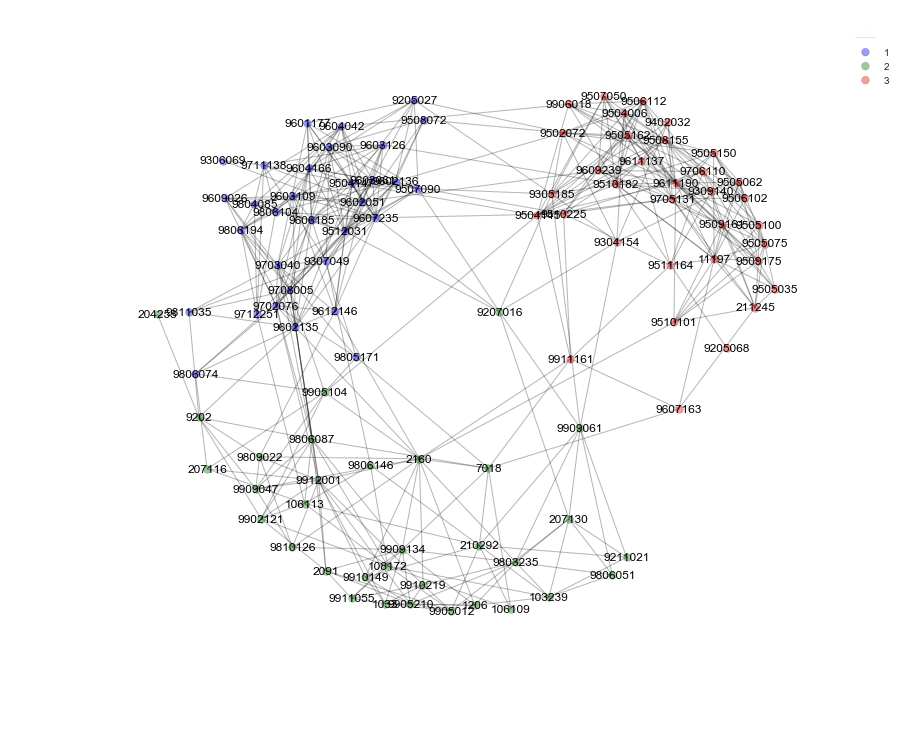

In [73]:
N = CommunityDetection(SubG,3,with_label = True)

In [78]:
node_information[node_information.id == 9207016]

,id,year,title,author,journal,abstract
10789,9207016,1992,noncompact symmetries in string theory,"Jnan Maharana, John H. Schwarz",Nucl.Phys.,noncompact groups similar to those that appear...


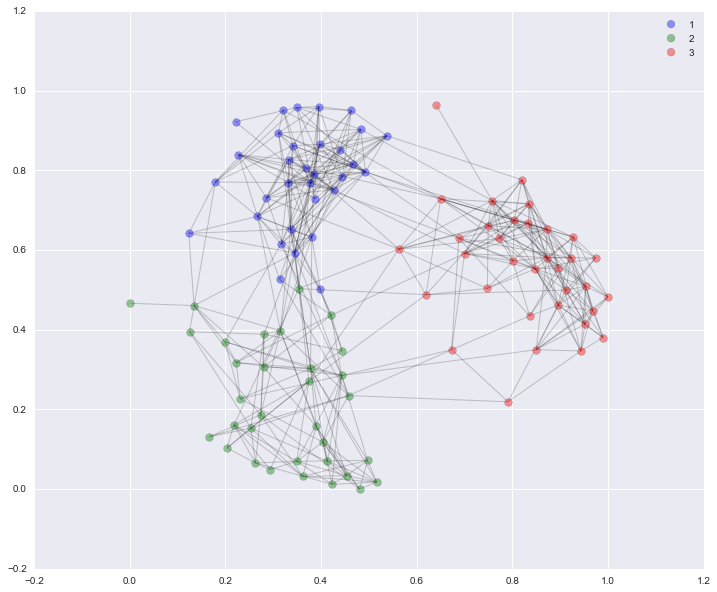

In [77]:
N = CommunityDetection(SubG,3,with_label = False)

In [82]:
N[0].head()

,Id,category
0,9602051,0
1,9603090,0
2,9711138,0
3,9603109,0
4,9603126,0
